In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from scipy.interpolate import make_interp_spline
from collections import defaultdict
from scipy.interpolate import interp1d
from flask import Flask, jsonify, request
from flask_cors import CORS
import random
app = Flask(__name__)
CORS(app)


In [ ]:
'''
fips
election_type
total_districts
total_represenatives

ensemble summary
    average_seat_share
    average_vote_share


per plan (one out of 5k)
    opportunity_representatives
    opportunity_districts
    dem_vote_share
    rep_vote_share
    total_reprentatives


    demographics
        black
        white
        hispanic
        asian

'''

In [344]:


def election_result_collection(data, json):

    planId = []
    democratsPercentage = []
    republicanPercentage = []
    total_plans = len(json.get("barData", []))
    
    for item in data:
        total_district = len(item.get("ids",{}))
        elec_res = item.get("elec_res", {})

        totals_for_party = elec_res.get("percents_for_party", {})
        dem_totals = totals_for_party.get("Democratic", {})
        rep_totals = totals_for_party.get("Republican", {})

        avg_dem_share = []
        avg_rep_share = []
        dem_seats = 0
        rep_seats = 0

        for district_id in dem_totals:
            #total votes (dem and rep) from the same disctrict (inside the district plan)
  
            total_votes = dem_totals[district_id] + rep_totals.get(district_id, 0)

            if total_votes > 0:
                dem_percentage = dem_totals[district_id] / total_votes * 100
                rep_percentage = rep_totals.get(district_id, 0) / total_votes * 100
            else:
                dem_percentage = 0
                rep_percentage = 0

            avg_dem_share.append(dem_percentage)
            avg_rep_share.append(rep_percentage)

            if dem_percentage > rep_percentage:
                dem_seats += 1
            elif rep_percentage > dem_percentage:
                rep_seats += 1


        total_plans+=1
        planId.append(total_plans)
        dem_share = round(np.mean(avg_dem_share)/100, 2)
        rep_share = round(np.mean(avg_rep_share)/100,2)
        democratsPercentage.append(dem_share)
        republicanPercentage.append(rep_share)
        json["totalDistricts"] = total_district
        json["democratAvgVoteShare"] = (
            json["democratAvgVoteShare"] * (total_plans - 1) + dem_share
        ) / total_plans
        json["republicanAvgVoteShare"] = (
            json["republicanAvgVoteShare"] * (total_plans - 1) + rep_share
        ) / total_plans
        json["democratAvgSeatShare"] = (
            json["democratAvgSeatShare"] * (total_plans - 1) + dem_seats / len(dem_totals)
        ) / total_plans
        json["republicanAvgSeatShare"] = (
            json["republicanAvgSeatShare"] * (total_plans - 1) + rep_seats / len(rep_totals)
        ) / total_plans

 

        
        
      
    ensembles = [ {"planId": v1, "democratsPercentage":v2, "republicanPercentage": v3  }
                for v1 ,v2, v3 in zip(planId, democratsPercentage, republicanPercentage)]
    json["barData"].extend(ensembles) 
def calculate_opportunity_SMD(data, json, minority='hispanic',opportunity_threshold=0):

    results = []

    for district_plan in data['barData']:
        plan_id = district_plan['planId']
        opportunity_districts = 0

        for district in district_plan['districts']:
            total_population = district['white'] + district['black'] + district['asian'] + district['hispanic']
            minoirty_population = district[minority]

            minority_proportion = minoirty_population / total_population 
            
            
            if minority_proportion >= opportunity_threshold:
                opportunity_districts += 1
            

        for plan in json['barData']:
            if plan['planId'] == plan_id:
                plan['opportunityRepresentatives'] = opportunity_districts  # SMD: 1 rep per district
                plan['opportunityDistricts'] = opportunity_districts
                
                break
    return results
def collect_ensemble_demographic(data,shapefile ,json):
    i = len(json.get("barData", []))
    planId = []
    white = []
    black = []
    asian = []
    hispanic = []
    for item in data:
    
        districts =  item.get("ids", {})
        demo_summary= {
                    "white": 0,
                    "black": 0,
                    "asian": 0,
                    "hispanic": 0
            }
        for district_id, precinct_ids  in districts.items():
       
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row["HPAC"]
        i+=1
        planId.append(i)
        white.append(demo_summary["white"])
        black.append(demo_summary["black"])
        asian.append(demo_summary["asian"])
        hispanic.append(demo_summary["hispanic"])

    ensembles = [ {"planId": v1, "white":v2, "black": v3, "asian": v4, "hispanic": v5  }
                for v1 ,v2, v3, v4, v5 in zip(planId, white, black, asian, hispanic)]
    
    json["barData"].extend(ensembles)                 
def collect_district_plan_demographic(data, shapefile, json):
    i = len(json.get("barData", []))  # Start planId based on existing data

    for item in data:
        districts = item.get("ids", {})
        district_demographics = []

        for district_id, precinct_ids in districts.items():
            
            demo_summary = {
                "districtId": district_id,
                "white": 0,
                "black": 0,
                "asian": 0,
                "hispanic": 0
            }

            
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row["HPAC"]

          
            district_demographics.append(demo_summary)

        
        i += 1
        json["barData"].append({
            "planId": i,
            "districts": district_demographics
        })
def collect_vote_seat_share_metrics(data, json):
    planId = []
    demVoteShare = []
    demSeatShare = []
    repSeatShare = []
    repVoteShare = []
    total_plans = len(json.get("barData", []))

    for item in data:
        total_districts = len(item.get("elec_res", {}).get("percents_for_party", {}).get("Democratic", {}))
        elec_res = item.get("elec_res", {})

        totals_for_party = elec_res.get("percents_for_party", {})
        dem_totals = totals_for_party.get("Democratic", {})
        rep_totals = totals_for_party.get("Republican", {})

        dem_seats = 0
        rep_seats = 0

        dem_vote_shares = []
        rep_vote_shares = []

        for district_id in dem_totals:
            dem_vote_share = dem_totals[district_id]
            rep_vote_share = rep_totals.get(district_id, 0)

            dem_vote_shares.append(dem_vote_share)
            rep_vote_shares.append(rep_vote_share)

            if dem_vote_share > rep_vote_share:
                dem_seats += 1
            elif rep_vote_share > dem_vote_share:
                rep_seats += 1

        avg_dem_vote_share = round(sum(dem_vote_shares) / total_districts, 2)
        avg_rep_vote_share = round(sum(rep_vote_shares) / total_districts, 2)
        dem_seat_share = round(dem_seats / total_districts, 2)
        rep_seat_share = round(rep_seats / total_districts, 2)

        
        total_plans += 1
        planId.append(total_plans)
        demVoteShare.append(avg_dem_vote_share)
        repVoteShare.append(avg_rep_vote_share)
        demSeatShare.append(dem_seat_share)
        repSeatShare.append(rep_seat_share)


    ensembles = [ 
                {"planId": v1,
                "demVoteShare":v2,
                "demSeatShare": v3 ,
                "repVoteShare": v4, 
                "repSeatShare": v5  }
                for v1 ,v2, v3 , v4,v5 in zip(planId, demVoteShare , demSeatShare, repVoteShare, repSeatShare)]

    json["barData"].extend(ensembles) 
def calculate_annotation_for_vote_seat_share(data): 
    bias = 0
    symmetry = 0
    responsiveness = 0

    dem_vote_share = np.array([entry['demVoteShare'] for entry in data['curveData']])
    rep_vote_share = np.array([entry['repVoteShare'] for entry in data['curveData']])
    total_districts = data['totalDistricts']
    
    # Calculate Democratic seat share cumulatively
    dem_seat_share = np.array([1 if vote > 0.5 else 0 for vote in dem_vote_share]).cumsum() / total_districts
    
    # Partisan Bias: Difference between seat share at 50% vote and 50%
    closest_to_50_index = np.argmin(np.abs(dem_vote_share - 0.5))
    bias = dem_seat_share[closest_to_50_index] - 0.5

    # Responsiveness: Average slope of the seats-votes curve in 45%-55% range
    in_range_indices = np.where((dem_vote_share >= 0.45) & (dem_vote_share <= 0.55))[0]
    slopes = []
    for i in range(len(in_range_indices) - 1):
        delta_vote = dem_vote_share[in_range_indices[i + 1]] - dem_vote_share[in_range_indices[i]]
        delta_seat = dem_seat_share[in_range_indices[i + 1]] - dem_seat_share[in_range_indices[i]]
        if delta_vote > 0:  # Avoid division by zero
            slopes.append(delta_seat / delta_vote)
    responsiveness = np.mean(slopes) if slopes else 0

    # Partisan Symmetry: Difference in seat shares at symmetric vote shares
    symmetry_differences = []
    for i, dem_vote in enumerate(dem_vote_share):
        symmetric_vote = 1 - dem_vote
        closest_symmetric_index = np.argmin(np.abs(dem_vote_share - symmetric_vote))
        if abs(dem_vote_share[closest_symmetric_index] - symmetric_vote) < 0.05:  # 5% tolerance
            sym_diff = dem_seat_share[i] - dem_seat_share[closest_symmetric_index]
            symmetry_differences.append(sym_diff)
    symmetry = np.mean(symmetry_differences) if symmetry_differences else 0

    # Add calculated metrics to the data dictionary
    data["bias"] = round(bias, 4)
    data["responsiveness"] = round(responsiveness, 4)
    data["symmetry"] = round(symmetry, 4)

    return data

    
def collect_box_and_whisker(data, json, races):
    total_districts = data["totalDistricts"]  # Use totalDistricts from the data
    districts_data = {f"District {i+1}": {race: [] for race in races} for i in range(total_districts)}

    # Collect data for each race as percentages
    for plan in data['barData']:
        for i, district in enumerate(plan['districts']):
            total_population = sum(district[race] for race in races)  # Calculate total population for the district
            for race in races:
                # Convert race population to percentage
                if total_population > 0:
                    percentage = (district[race] / total_population) * 100
                else:
                    percentage = 0
                districts_data[f"District {i+1}"][race].append(percentage)

    # Calculate statistics for each district and race
    enacted_plan = data['barData'][0]
    enacted_values = {}
    for i, district in enumerate(enacted_plan["districts"]):
        total_population = sum(district[race] for race in races)
        enacted_values[f"District {i+1}"] = {}
        for race in races:
            if total_population > 0:
                enacted_values[f"District {i+1}"][race] = (district[race] /total_population) * 100
            else:
                enacted_values[f"District {i+1}"][race] = 0


    for district, race_values in districts_data.items():
        stats = {"binNo": int(district.split()[-1])}
        for race, values in race_values.items():
            values = np.array(values)
            stats[race] = {
                "min": float(np.min(values)),
                "q1": float(np.percentile(values, 25)),
                "median": float(np.median(values)),
                "q3": float(np.percentile(values, 75)),
                "max": float(np.max(values)),
                "enactedValue": round(enacted_values[district][race],2)  
            }
        json["boxes"].append(stats)
def collec_metrics_plan_specific(data, json, plan_type):
    districtId = []
    democratsPercentage = []
    republicanPercentage = []
    opportunityThreshold = []
    isOpportunityDistrict = []
    white = []
    black = []
    asian = []
    hispanic = []
    dem_votes = 0
    rep_votes = 0
    total_votes = []
    
    for item in data["features"]:
        districts = item["properties"]
        demographics =  districts["demographics"]

        districtId.append(districts.get("DISTRICTNO", None))
        democratsPercentage.append(districts.get("demRatio", 0))
        #republicanPercentage.append(districts.get("repRatio", 0))
        republicanPercentage.append(abs(1 - districts.get("demRatio" , 0)))
        opportunityThreshold.append(districts.get("oppThreshold", 0))
        isOpportunityDistrict.append(districts.get("oppDistrict", False))
        white.append(demographics.get("white", 0))
        black.append(demographics.get("black", 0))
        asian.append(demographics.get("asian", 0))
        hispanic.append(demographics.get("latin", 0))
        total_votes.append(demographics.get("latin", 0) + demographics.get("asian", 0) + demographics.get("black", 0) + demographics.get("white", 0))
        dem_votes += (demographics.get("white", 0) + demographics.get("black", 0) + demographics.get("asian", 0) + demographics.get("latin", 0)) * districts.get("demRatio", 0)
        rep_votes += (demographics.get("white", 0) + demographics.get("black", 0) + demographics.get("asian", 0) + demographics.get("latin", 0)) * (1 - districts.get("demRatio", 0))
    
   
    district_metrics = [
        {
            "districtId": dId,
            "democratsPercentage": dPct,
            "republicanPercentage": rPct,
            "opportunityThreshold": oThresh,
            "isOpportunityDistrict": isOpp,
            "white": w,
            "black": b,
            "asian": a,
            "hispanic": h,
            "totalVotes": votes
        }
        for dId, dPct, rPct, oThresh, isOpp, w, b, a, h , votes, in zip(
            districtId, democratsPercentage, republicanPercentage,
            opportunityThreshold, isOpportunityDistrict,
            white, black, asian, hispanic, total_votes
        )
    ]

    json["districts"].extend(district_metrics)
    json["demTotalVotes"] = round(dem_votes)
    json["repTotalVotes"] = round(rep_votes)
    #json["planType"] = plan_type
def ensembles_box_and_whisker_plot(data, comparison_basis):
    
    sorted_boxes = sorted(data["boxes"], key=lambda x: x[comparison_basis]["median"])

    bins = [f"District {box['binNo']}" for box in sorted_boxes]
    min_values = [box[comparison_basis]["min"] for box in sorted_boxes]
    q1_values = [box[comparison_basis]["q1"] for box in sorted_boxes]
    median_values = [box[comparison_basis]["median"] for box in sorted_boxes]
    q3_values = [box[comparison_basis]["q3"] for box in sorted_boxes]
    max_values = [box[comparison_basis]["max"] for box in sorted_boxes]
    enacted_values = [box[comparison_basis]["enactedValue"] for box in sorted_boxes]

    # Set up the figure
    plt.figure(figsize=(10, 6))

    for i, (min_val, q1, median, q3, max_val, enacted_val) in enumerate(zip(min_values, q1_values, median_values, q3_values, max_values, enacted_values)):
        # Whiskers
        plt.plot([i + 1, i + 1], [min_val, max_val], color='black', zorder=2, label="Whiskers" if i == 0 else "")
        # Add horizontal lines at min and max
        plt.hlines(min_val, i + 0.8, i + 1.2, color='black', linewidth=1)
        plt.hlines(max_val, i + 0.8, i + 1.2, color='black', linewidth=1)
        # Box
        plt.bar(
            i + 1, q3 - q1, bottom=q1, width=0.5, color='blue', alpha=0.8,
            edgecolor='black', zorder=1, label="IQR (Q1-Q3)" if i == 0 else ""
        )
        # Enacted Value
        if enacted_val is not None:
            plt.scatter(
                i + 1, enacted_val, color='orange', zorder=4, label="Enacted Plan" if i == 0 else ""
            )

    # Add x-axis labels
    plt.xticks(range(1, len(bins) + 1), bins)
    # Add title and axis labels
    plt.title(f"Nevada SMD Ensemble: Box & Whisker Plot for {comparison_basis.capitalize()} Population Percent", fontsize=14)
    plt.xlabel("Districts", fontsize=12)
    plt.ylabel("Population Percent (%)", fontsize=12)
    # Add legend
    plt.legend(loc="upper right")
    # Add gridlines for y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Adjust layout
    plt.tight_layout()
    # Show the plot
    plt.show()

def collect_box_and_whisker_bins(data, json, races, bin_size=10):
    """
    Collect box and whisker statistics for demographics, classifying percentages into bins.
    
    Args:
        data (dict): Input data containing district plans.
        json (dict): Output JSON to store the results.
        races (list): List of demographics (e.g., ["white", "black", "asian", "hispanic"]).
        bin_size (int): Size of bins to group percentages, default is 10 (e.g., [0-10], [11-20], etc.).
    """
    bins_range = [(i, i + bin_size - 1) for i in range(0, 100, bin_size)]  # Bin ranges
    bins_dict = {f"[{low}-{high}]": {race: [] for race in races} for low, high in bins_range}

    # Aggregate data into bins for all plans
    for plan in data['barData']:
        for district in plan['districts']:
            total_population = sum(district[race] for race in races)
            for race in races:
                percentage = (district[race] / total_population) * 100 if total_population > 0 else 0
                for low, high in bins_range:
                    if low <= percentage <= high:
                        bin_label = f"[{low}-{high}]"
                        bins_dict[bin_label][race].append(percentage)
                        break

    # Place enacted plan data into bins
    enacted_plan = data['barData'][0]
    enacted_bins = {f"[{low}-{high}]": {race: [] for race in races} for low, high in bins_range}
    for district in enacted_plan["districts"]:
        total_population = sum(district[race] for race in races)
        for race in races:
            percentage = (district[race] / total_population) * 100 if total_population > 0 else 0
            for low, high in bins_range:
                if low <= percentage <= high:
                    bin_label = f"[{low}-{high}]"
                    enacted_bins[bin_label][race].append(percentage)
                    break

    # Calculate statistics for each bin and race
    json["boxes"] = []
    for bin_label in bins_dict:
        stats = {"bin": bin_label}
        for race in races:
            values = np.array(bins_dict[bin_label][race])
            enacted_values = np.array(enacted_bins[bin_label][race])
            if len(values) > 0:
                stats[race] = {
                    "min": float(np.min(values)),
                    "q1": float(np.percentile(values, 25)),
                    "median": float(np.median(values)),
                    "q3": float(np.percentile(values, 75)),
                    "max": float(np.max(values)),
                    "enactedValue": round(float(np.mean(enacted_values)) if len(enacted_values) > 0 else 0, 2)
                }
            else:
                stats[race] = {
                    "min": 0, "q1": 0, "median": 0, "q3": 0, "max": 0, "enactedValue": 0
                }
        json["boxes"].append(stats)
def ensembles_box_and_whisker_plot_bins(data, comparison_basis, bin_size=10):
    """
    Constructs a box-and-whisker plot where the bins represent percentage ranges (e.g., [0-10], [11-20], ...).
    
    Args:
        data (dict): Input data containing box statistics and binned data.
        comparison_basis (str): Demographic basis to analyze (e.g., "white", "hispanic").
        bin_size (int): Interval size for bins, default is 10.
    """
    # Extract binned data
    bins_range = [(i, i + bin_size - 1) for i in range(0, 100, bin_size)]  
    bins_labels = [f"[{low}-{high}]" for low, high in bins_range]  # Bin labels for the x-axis

    # Initialize lists to collect values for each bin
    bin_values = {label: [] for label in bins_labels}

    # Aggregate values into their respective bins
    for district in data["boxes"]:
        for low, high in bins_range:
            bin_label = f"[{low}-{high}]"
            value = district[comparison_basis]["median"]
            if low <= value <= high:
                bin_values[bin_label].append(value)

    # Prepare statistics (min, Q1, median, Q3, max) for each bin
    stats = {bin_label: {"min": 0, "q1": 0, "median": 0, "q3": 0, "max": 0} for bin_label in bins_labels}
    for bin_label, values in bin_values.items():
        if values:  # Only process bins with data
            stats[bin_label]["min"] = np.min(values)
            stats[bin_label]["q1"] = np.percentile(values, 25)
            stats[bin_label]["median"] = np.median(values)
            stats[bin_label]["q3"] = np.percentile(values, 75)
            stats[bin_label]["max"] = np.max(values)

    # Extract values for the plot
    bins = bins_labels
    min_values = [stats[bin]["min"] for bin in bins]
    q1_values = [stats[bin]["q1"] for bin in bins]
    median_values = [stats[bin]["median"] for bin in bins]
    q3_values = [stats[bin]["q3"] for bin in bins]
    max_values = [stats[bin]["max"] for bin in bins]

    # Plot
    plt.figure(figsize=(12, 6))

    for i, (min_val, q1, median, q3, max_val) in enumerate(zip(min_values, q1_values, median_values, q3_values, max_values)):
        # Whiskers
        plt.plot([i + 1, i + 1], [min_val, max_val], color='black', zorder=2, label="Whiskers" if i == 0 else "")
        # Add horizontal lines at min and max
        plt.hlines(min_val, i + 0.8, i + 1.2, color='black', linewidth=1)
        plt.hlines(max_val, i + 0.8, i + 1.2, color='black', linewidth=1)
        # Box
        plt.bar(
            i + 1, q3 - q1, bottom=q1, width=0.5, color='blue', alpha=0.8,
            edgecolor='black', zorder=1, label="IQR (Q1-Q3)" if i == 0 else ""
        )
        # Median
        plt.hlines(median, i + 0.8, i + 1.2, color='orange', linewidth=2, label="Median" if i == 0 else "")

    # X-axis labels
    plt.xticks(range(1, len(bins) + 1), bins, rotation=45)
    # Title and axis labels
    plt.title(f"Nevada SMD Ensemble: Box & Whisker Plot for {comparison_basis.capitalize()} Population Percent by Bin", fontsize=14)
    plt.xlabel("Percentage Ranges (Bins)", fontsize=12)
    plt.ylabel("Population Percent (%)", fontsize=12)
    # Legend and grid
    plt.legend(loc="upper right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [345]:
nv_box_ans_whisker_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "boxes": []

    }
races = ["white", "black", "asian", "hispanic"]
collect_box_and_whisker_bins(nv_demographic_data, nv_box_ans_whisker_data, races, 20)
nv_box_ans_whisker_data

{'fips': 'NV',
 'electionType': 'SMD',
 'totalDistricts': 4,
 'boxes': [{'bin': '[0-19]',
   'white': {'min': 0,
    'q1': 0,
    'median': 0,
    'q3': 0,
    'max': 0,
    'enactedValue': 0},
   'black': {'min': 4.942103693380527,
    'q1': 6.779285446588497,
    'median': 13.017147923004167,
    'q3': 15.851899482003832,
    'max': 18.998672247727068,
    'enactedValue': 13.17},
   'asian': {'min': 7.370925641115951,
    'q1': 9.933277805009187,
    'median': 12.153731245045662,
    'q3': 15.59716007487523,
    'max': 18.99983367522315,
    'enactedValue': 12.92},
   'hispanic': {'min': 1.3305460755357421,
    'q1': 1.7399742708359192,
    'median': 2.2899540379335623,
    'q3': 2.5879855822127467,
    'max': 3.2765187408679917,
    'enactedValue': 2.15}},
  {'bin': '[20-39]',
   'white': {'min': 0,
    'q1': 0,
    'median': 0,
    'q3': 0,
    'max': 0,
    'enactedValue': 0},
   'black': {'min': 20.0,
    'q1': 21.693640989381596,
    'median': 23.837522790817175,
    'q3': 27.14

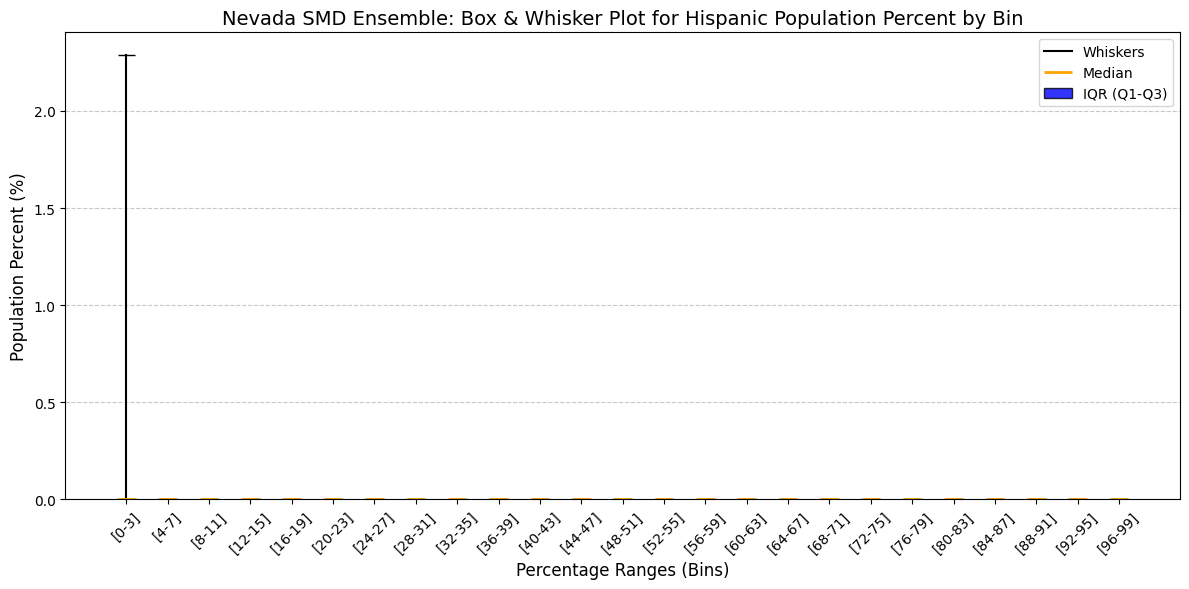

In [350]:
ensembles_box_and_whisker_plot_bins(nv_box_ans_whisker_data, "hispanic", 4)

In [320]:

shp_path = 'nv_2020_final/nv_2020_final.shp'
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['ASN'] = shapefile['ASN'].fillna(0)
shapefile['AFAM'] = shapefile['AFAM'].fillna(0)
shapefile['WHT'] = shapefile['WHT'].fillna(0)
shapefile['HPAC'] = shapefile['HPAC'].fillna(0)

with open('random_district0.json', 'r') as file:
    raw_data_district0 = json.load(file)
with open('random_district2.json', 'r') as file:
    raw_data_district2 = json.load(file)
with open('random_district4.json', 'r') as file:
    raw_data_district4 = json.load(file)
with open('random_district100.json', 'r') as file:
    raw_data_district100 = json.load(file)
with open('random_district101.json', 'r') as file:
    raw_data_district101 = json.load(file)
with open('random_district110.json', 'r') as file:
    raw_data_district110 = json.load(file)

nv_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 0,
    "democratAvgVoteShare": 0,
    "democratAvgSeatShare": 0,
    "republicanAvgVoteShare": 0,
    "republicanAvgSeatShare": 0,
    "barData": []

    }
nv_demographic_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "barData": []

    }
nv_vote_seat_share_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 0,
    "symmetry": 0.5,
    "bias": 2.5,
    "responsiveness": 0.75,
    "barData": []

    }
nv_box_ans_whisker_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "boxes": []

    }
races = ["white", "black", "asian", "hispanic"]

collect_district_plan_demographic(raw_data_district0,shapefile ,nv_demographic_data)
collect_district_plan_demographic(raw_data_district2,shapefile ,nv_demographic_data)
collect_district_plan_demographic(raw_data_district4,shapefile ,nv_demographic_data)
collect_district_plan_demographic(raw_data_district100,shapefile ,nv_demographic_data)
collect_district_plan_demographic(raw_data_district101,shapefile ,nv_demographic_data)
collect_district_plan_demographic(raw_data_district110,shapefile ,nv_demographic_data)

election_result_collection(raw_data_district0, nv_data)
election_result_collection(raw_data_district2, nv_data)
election_result_collection(raw_data_district4, nv_data)
election_result_collection(raw_data_district100, nv_data)
election_result_collection(raw_data_district101, nv_data)
election_result_collection(raw_data_district110, nv_data)

calculate_opportunity_SMD(nv_demographic_data, nv_data, 'black', 0.20)


file_path = 'nv_ensemble_bar.json'
with open(file_path, 'w') as json_file:
    json.dump(nv_data, json_file, indent=4)

collect_box_and_whisker(nv_demographic_data, nv_box_ans_whisker_data, races)

file_path = 'nv_ensemble_box_and_whisker.json'
with open(file_path, 'w') as json_file:
    json.dump(nv_box_ans_whisker_data, json_file, indent=4)





'''



collect_vote_seat_share_metrics(raw_data_district0, nv_vote_seat_share_data)
collect_vote_seat_share_metrics(raw_data_district2, nv_vote_seat_share_data)
collect_vote_seat_share_metrics(raw_data_district4, nv_vote_seat_share_data)
collect_vote_seat_share_metrics(raw_data_district100, nv_vote_seat_share_data)
collect_vote_seat_share_metrics(raw_data_district101, nv_vote_seat_share_data)
calculate_annotation_for_vote_seat_share(nv_vote_seat_share_data)


file_path = 'nv_ensemble_vote_seat_share.json'
with open(file_path, 'w') as json_file:
    json.dump(nv_vote_seat_share_data, json_file, indent=4)

'''




"\n\n\n\ncollect_vote_seat_share_metrics(raw_data_district0, nv_vote_seat_share_data)\ncollect_vote_seat_share_metrics(raw_data_district2, nv_vote_seat_share_data)\ncollect_vote_seat_share_metrics(raw_data_district4, nv_vote_seat_share_data)\ncollect_vote_seat_share_metrics(raw_data_district100, nv_vote_seat_share_data)\ncollect_vote_seat_share_metrics(raw_data_district101, nv_vote_seat_share_data)\ncalculate_annotation_for_vote_seat_share(nv_vote_seat_share_data)\n\n\nfile_path = 'nv_ensemble_vote_seat_share.json'\nwith open(file_path, 'w') as json_file:\n    json.dump(nv_vote_seat_share_data, json_file, indent=4)\n\n"

# NV SMD SPECIFIC PLAN JSON GENERATION + POPULATION

In [313]:
interesting_plans_data = []
with open('nv_smd_demfavored0.json', 'r') as file:
    nv_smd_demfavored = json.load(file)
    interesting_plans_data.append(nv_smd_demfavored)
with open('nv_smd_repfavored0.json', 'r') as file:
    nv_smd_repfavored = json.load(file)
    interesting_plans_data.append(nv_smd_repfavored)
with open('nv_smd_fair0.json', 'r') as file:
    nv_smd_fair = json.load(file)
    interesting_plans_data.append(nv_smd_fair)
with open('nv_smd_average0.json', 'r') as file:
    nv_smd_average = json.load(file)
    interesting_plans_data.append(nv_smd_average)
with open('ramdom_district.json', 'r') as file:
    nv_smd_enacted = json.load(file)
    interesting_plans_data.append(nv_smd_enacted)


interesting_plans = ["DEMFAVORED", "REPFAVORED", "FAIR", "AVERAGE", "ENACTED"]

for plan_name, plan_data in zip(interesting_plans, interesting_plans_data):


    nv_plan_specific = {
        "fips": "NV",
        "electionType": "SMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "districts": []
        }
    collec_metrics_plan_specific(plan_data, nv_plan_specific, plan_name)

    file_path = f'nv_{plan_name}.json'
    with open(file_path, 'w') as json_file:
        json.dump(nv_plan_specific, json_file, indent=4)


In [314]:

def vote_seat_share_data_collectiotion_specific_plan(data ,json, planType ):

    districts = data["districts"]
    total_districts = data["totalDistricts"]
    curve_data = []
    dem_seats = 0
    rep_seats = 0


        

    for district in districts:
        dem_vote_share = district["democratsPercentage"]
        rep_vote_share = district["republicanPercentage"]

        
        if dem_vote_share > rep_vote_share:
            dem_seats +=1
        elif rep_vote_share > dem_vote_share:
            rep_seats +=1
   
        #dem_seat_share = round(dem_seats/ total_districts , 2)
        #rep_seat_share = round(rep_seats/ total_districts , 2)
            #"demSeatShare": dem_seat_share, "repSeatShare": rep_seat_share
 
        curve_data.append({
            "districtId": district["districtId"],
            "demVoteShare": dem_vote_share,
            "repVoteShare": rep_vote_share,
            "totalVotes": district["totalVotes"]
        
            
            
        })

    json["curveData"] = curve_data
    json["totalDistricts"] = len(districts)
    json["repTotalVotes"]= data["demTotalVotes"]
    json["demTotalVotes"]= data["repTotalVotes"]
    json["democratsSeats"]= dem_seats
    json["republicanSeats"]= rep_seats



interesting_plans_data = []
with open('nv_demFavored.json', 'r') as file:
    nv_smd_demfavored = json.load(file)
    interesting_plans_data.append(nv_smd_demfavored)
with open('nv_RepFavored.json', 'r') as file:
    nv_smd_repfavored = json.load(file)
    interesting_plans_data.append(nv_smd_repfavored)
with open('nv_Fair.json', 'r') as file:
    nv_smd_fair = json.load(file)
    interesting_plans_data.append(nv_smd_fair)
with open('nv_Average.json', 'r') as file:
    nv_smd_average = json.load(file)
    interesting_plans_data.append(nv_smd_average)
with open('nv_Enacted.json', 'r') as file:
    nv_smd_enacted = json.load(file)
    interesting_plans_data.append(nv_smd_enacted)

interesting_plans = ["DEMFAVORED", "REPFAVORED", "FAIR", "AVERAGE", "ENACTED"]

for plan_name, plan_data in zip(interesting_plans, interesting_plans_data):


    nv_plan_specific = {
        "fips": "NV",
        "electionType": "SMD",
        "totalDistricts": 4,
        "characteristic": plan_name,
        "democratsSeats": 0,
        "republicanSeats": 0,
        "demTotalVotes": 0,
        "repTotalVotes": 0,
        "bias": 0,
        "symmetry": 0,
        "responsiveness": 0,
        "curveData": []
        }
    vote_seat_share_data_collectiotion_specific_plan(plan_data ,nv_plan_specific, plan_name)
    calculate_annotation_for_vote_seat_share(nv_plan_specific)
    
    file_path = f'nv_{plan_name}.json'
    with open(file_path, 'w') as json_file:
        json.dump(nv_plan_specific, json_file, indent=4)

In [115]:
simulation = pd.DataFrame(data['curveData'])
simulation['dem_votes'] = simulation['totalVotes'] * simulation['demVoteShare']
simulation['rep_votes'] = simulation['totalVotes'] * simulation['repVoteShare']
simulation['seat'] = simulation.apply(lambda x: 'rep' if x['repVoteShare'] > 0.5 else 'dem', axis = 1)
simulation['dem_votes']

,districtId,demVoteShare,repVoteShare,totalVotes,dem_votes,rep_votes,seat
0,1,0.405267,0.594733,486939,197340.110891,289598.889109,rep
1,2,0.542960,0.457040,839831,455994.266824,383836.733176,dem
2,3,0.555394,0.444606,857831,476434.063117,381396.936883,dem
3,4,0.490224,0.509776,576165,282449.984754,293715.015246,rep


In [126]:
np.clip(3,0,1)

1

In [164]:
np.average([1,2,3])

2.0

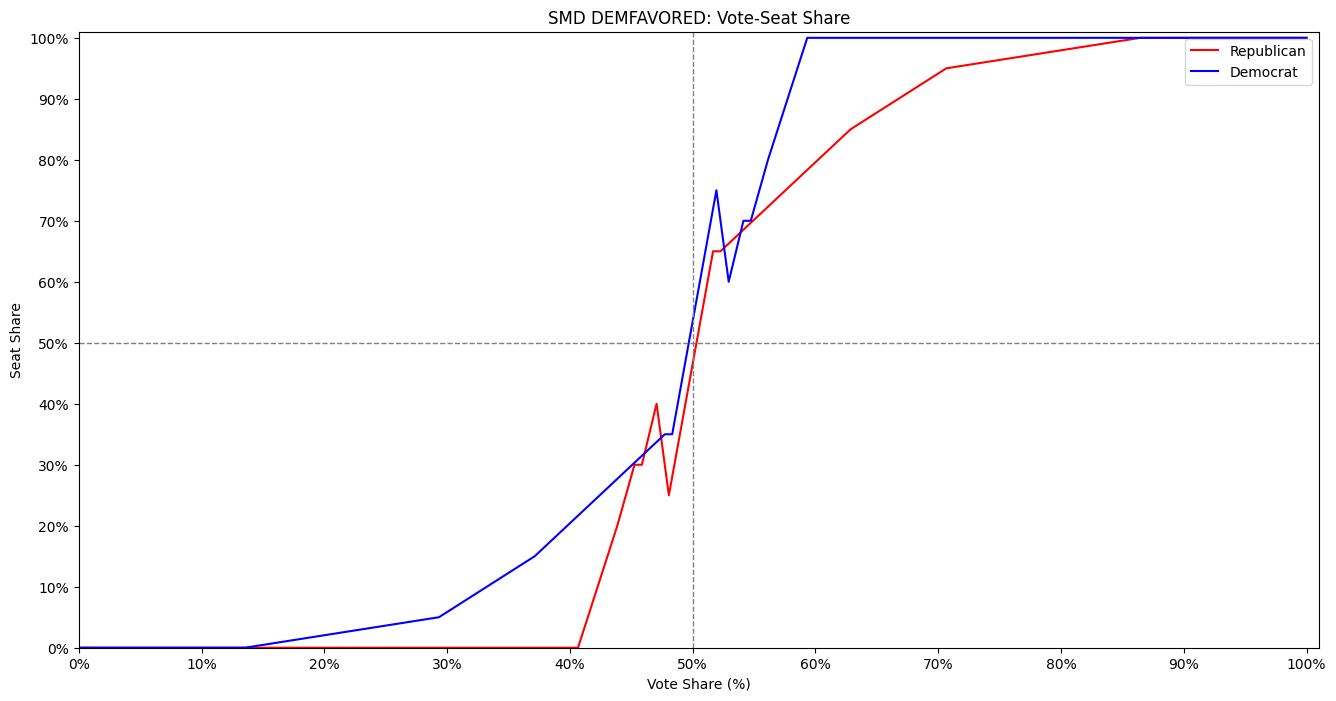

In [321]:


with open('nv_DEMFAVORED.json', 'r') as file:
    data = json.load(file)

random.seed(42)
plt.figure(figsize=(16, 8))

dem_df = pd.DataFrame([[0, 0], [1, 1]], columns = ['x', 'y'])
rep_df = pd.DataFrame([[0, 0], [1, 1]], columns = ['x', 'y'])

simulation = pd.DataFrame(data['curveData'])

total_dem_vote_share = (simulation['totalVotes'] * simulation['demVoteShare']).sum() / simulation['totalVotes'].sum()
total_dem_seat_share = (simulation['demVoteShare'] > 0.5).sum() / len(simulation)

dem_df.loc[len(dem_df)] = [total_dem_vote_share, total_dem_seat_share]
rep_df.loc[len(rep_df)] = [1 - total_dem_vote_share, 1 - total_dem_seat_share]

#simulation2 = simulation.copy()
# add the increment to dem vote share across districts
for i in range(50):
    dem_vote_share = simulation['demVoteShare']
    rep_vote_share = simulation['repVoteShare']
    totalVotes = simulation['totalVotes']

    dem_vote_shares = []
    dem_seat_shares = []
    increments = []
    for j in range(5):
        increment = 0.01 + random.randint(-5, 5) / 100
        increments.append(increment)

        tem_dem_vote_share = dem_vote_share
        tem_dem_vote_share += increment
        tem_dem_vote_share = np.clip(tem_dem_vote_share, 0, 1)

        dem_vote_shares.append((totalVotes * tem_dem_vote_share).sum() / totalVotes.sum())
        dem_seat_shares.append((tem_dem_vote_share > 0.5).sum() / len(simulation))
        
    avg_dem_vote_share = np.average(dem_vote_shares)
    avg_dem_seat_share = np.average(dem_seat_shares)

    simulation['demVoteShare'] += np.average(increments)
    simulation['repVoteShare'] -= np.average(increments)

    dem_df.loc[len(dem_df)] = [avg_dem_vote_share, avg_dem_seat_share]
    rep_df.loc[len(rep_df)] = [1 - avg_dem_vote_share, 1 - avg_dem_seat_share]


for i in range(50):
    dem_vote_share = simulation['demVoteShare']
    rep_vote_share = simulation['repVoteShare']
    totalVotes = simulation['totalVotes']

    dem_vote_shares = []
    dem_seat_shares = []
    increments = []
    for j in range(5):
        increment = -0.01 + random.randint(-5, 5) / 100
        increments.append(increment)

        tem_dem_vote_share = dem_vote_share
        tem_dem_vote_share += increment
        tem_dem_vote_share = np.clip(tem_dem_vote_share, 0, 1)

        dem_vote_shares.append((totalVotes * tem_dem_vote_share).sum() / totalVotes.sum())
        dem_seat_shares.append((tem_dem_vote_share > 0.5).sum() / len(simulation))
        
    avg_dem_vote_share = np.average(dem_vote_shares)
    avg_dem_seat_share = np.average(dem_seat_shares)

    simulation['demVoteShare'] += np.average(increments)
    simulation['repVoteShare'] -= np.average(increments)

    dem_df.loc[len(dem_df)] = [avg_dem_vote_share, avg_dem_seat_share]
    rep_df.loc[len(rep_df)] = [1 - avg_dem_vote_share, 1 - avg_dem_seat_share]

dem_df = dem_df.sort_values(by = 'x')
rep_df = rep_df.sort_values(by = 'x')

plt.plot(rep_df['x'], rep_df['y'], label = 'Republican', color = 'red')
plt.plot(dem_df['x'], dem_df['y'], label = 'Democrat', color = 'blue')

# Set the axis limits
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)

# Set the ticks to show percentages
tick_positions = np.arange(0, 1.1, 0.1)  # Positions for ticks (0% to 100%)
tick_labels = [f"{int(tick * 100)}%" for tick in tick_positions]  # Labels as percentages

plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)

plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
plt.axvline(0.5, color='gray', linestyle='--', linewidth=1)

# Labels and legend
plt.title(f'SMD {data["characteristic"]}: Vote-Seat Share')
plt.xlabel("Vote Share (%)")
plt.ylabel("Seat Share")
plt.legend()
plt.show()

In [295]:
with open('nv_demFavored.json', 'r') as file:
    nv_smd_demfavored = json.load(file)
calculate_annotation_for_vote_seat_share(nv_smd_demfavored)
nv_smd_demfavored

{'fips': 'NV',
 'electionType': 'SMD',
 'totalDistricts': 4,
 'characteristic': 'DEMFAVORED',
 'democratsSeats': 3,
 'republicanSeats': 1,
 'demTotalVotes': 1326920,
 'repTotalVotes': 1433846,
 'curveData': [{'districtId': 1,
   'demVoteShare': 0.6737979476546605,
   'repVoteShare': 0.3262020523453395,
   'totalVotes': 465988},
  {'districtId': 2,
   'demVoteShare': 0.4491702912698396,
   'repVoteShare': 0.5508297087301604,
   'totalVotes': 912337},
  {'districtId': 3,
   'demVoteShare': 0.5197110994791434,
   'repVoteShare': 0.4802889005208566,
   'totalVotes': 817627},
  {'districtId': 4,
   'demVoteShare': 0.5048374498811032,
   'repVoteShare': 0.49516255011889676,
   'totalVotes': 564814}],
 'bias': 0.25,
 'symmetry': -0.125,
 'responsiveness': None}